<center>
    <h1> Machine Learning for Computer Vision</h1>
    <h2> Project Work </h2>
    <a href="mailto:matteo.donati10@studio.unibo.it">Matteo Donati</a> (ID: 0001032227)
</center>

<br>

The paper by Guo et al. (2021)<sup>[[1]](#references)</sup> proposes the novel CMT architecture for visual recognition. This architecture tries to bring the advantage of transformers to capture long-range dependencies, and of CNNs to extract local information. Indeed, the authors of such paper state that the main problems of transformer-based models, when compared to CNNs, are related to: 

- the creation of image patches. This practice ignores the fundamental difference between sequence-based NLP tasks and image-based vision tasks, resulting in a non-optimal extraction of local information;

- the fact that transformers do not exploit multi-scale and low resolution features due to the fixed patch size. This fact could pose a big challenge to dense prediction tasks such as detection and segmentation.

Regarding the different versions of CMT, the authors proposes four different architectures that are obtained using a specific compound scaling strategy, starting from the CMT-S version. This strategy is defined considering a depth $\alpha^{\phi}$, a width $\beta^{\phi}$ and input resolution $\gamma^{\phi}$ in such a way that $\alpha \cdot \beta^{1.5} \cdot \gamma^{2} \approx 2.5$ where $\alpha \geq 1, \beta \geq 1, \gamma \geq 1$. For the  In particular, the following table shows all the possible CMT versions:

<br>

<center>
  <table>
    <tr>
      <td>Version</td>
      <td><center>Input resolution</center></td>
      <td><center># Parameters</center></td>
      <td><center># FLOPs</center></td>
    </tr>
    <tr>
      <td>CMT-Ti</td>
      <td><center>160 &times 160</center></td>
      <td><center>9.49M</center></td>
      <td><center>0.64B</center></td>
    </tr>
    <tr>
      <td>CMT-XS</td>
      <td><center>192 &times 192</center></td>
      <td><center>15.24M</center></td>
      <td><center>1.54B</center></td>
    </tr>
    <tr>
      <td>CMT-S</td>
      <td><center>224 &times 224</center></td>
      <td><center>25.14M</center></td>
      <td><center>4.04B</center></td>
    </tr>
    <tr>
      <td>CMT-B</td>
      <td><center>256 &times 256</center></td>
      <td><center>45.72M</center></td>
      <td><center>9.33B</center></td>
    </tr>
  </table>
  Table 1: CMT versions
</center>

<br>

Each version of CMT is composed of:

- a stem block, used for fine-grained feature extraction and to reduce the dimensionality of the input image;

- multiple stacks of CMT blocks that apply lightweight multi-head self-attention by first enhancing local information by means of depthwise convolutions. In particular, there exist one stack of CMT blocks for each possible stage (i.e. scale). In order to produce the hierarchical representation, a patch embedding layer consisting of a convolution and a layer normalization is applied before each stage;

- a global average pooling layer, a projection layer and a classification head.

This notebook proposes a non-official implementation of the CMT-Ti architecture and studies the capabilities of such architecture by modifying the lightweight attention mechanism used by CMT. Lastly, it compares the computed results with the ones obtained by training, from scratch, a similar network in terms of total number of parameters (namely, ResNet-18).

## Libraries

The following cells install and import all useful libraries. In particular, the FLOPs count is implemented using the [Flop Counter for PyTorch Models](https://github.com/facebookresearch/fvcore/blob/main/docs/flop_count.md) by Meta Research.

In [1]:
!pip install -U "git+https://github.com/facebookresearch/fvcore"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/fvcore to /tmp/pip-req-build-i3xov6f2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore /tmp/pip-req-build-i3xov6f2
  Resolved https://github.com/facebookresearch/fvcore to commit fd5043ff8b2e6790f5bd7c9632695c68986cc658
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5-py3-none-any.whl size=65314 sha256=97716e7d9bf4a3de781d3fdb877d58a1555c21ad96f1486e143da3bf004a53c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-sqxkpr7i/wheels/51/52/07/e1a7fde1786c36d1e4ca408afe8979cfffa255c078f3725d45
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=cd20983202376ea2597a884531a3410bf49427ae6b11c807b4ab65ebe50449

In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms as T
import multiprocessing as mp
from matplotlib import pyplot as plt
from fvcore.nn import FlopCountAnalysis, flop_count_str
import pickle
from tqdm import tqdm
from sklearn.metrics import classification_report
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

The `set_producibility` sets the a specific random seed so as to obtain reproducible results. Each model has been trained by first setting the random seed to `0`.

In [3]:
def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

set_reproducibility(0)

## Data Loading and Preprocessing

The following `get_cifar10` and `create_data_loaders` functions download the CIFAR-10 dataset and create proper `DataLoader` objects that can be used to train and test the different models.

In [ ]:
# Retrieves the CIFAR10 dataset.
def get_cifar10(train_transform = None, test_transform = None):

  # Downloading the training set.
  train_dataset =  datasets.CIFAR10(
    root = "CIFAR10",
    train = True,
    transform = train_transform,
    download = True
  )

  # Downloading the test set.
  test_dataset = datasets.CIFAR10(
    root = "CIFAR10",
    train = False,
    transform = test_transform,
    download = True
  )

  # Returning the two sets.
  return train_dataset, test_dataset

# Fuction that creates train, validation and test data loaders.
def create_data_loaders(train_transform, 
                        test_transform, 
                        img_size = 224, 
                        split = (0.8, 0.2), 
                        batch_size = 32, 
                        num_workers = 1):

  # Retrieving CIFAR10.
  train_dataset, test_dataset = get_cifar10(train_transform, test_transform)

  # Splitting train_dataset to create a validation set.
  train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, 
                                                             (int(len(train_dataset) * split[0]), 
                                                              int(len(train_dataset) * split[1])))

  # Train data loader.
  train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    pin_memory = True,
    drop_last = True,
    sampler = None
  )

  # Validation data loader.
  val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = num_workers,
    pin_memory = True,
    drop_last = False,
    sampler = None
  )

  # Test data loader.
  test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = num_workers,
    pin_memory = True,
    drop_last = False,
    sampler = None
  )

  # Returning the three data loaders.
  return train_loader, val_loader, test_loader

The training `DataLoader` object include different transformations that are used to augment the training dataset. In particular, the set of transformations include random crops, random flips and random rotations. Each split of the original dataset has been divided using a batch size of $32$.

In order to use both CMT-Ti ($160 \times 160$ input resolution) and ResNet-18 ($224 \times 224$ input resolution) with $32 \times 32$ images, all CIFAR-10 images have been transformed into $224 \times 224$ images using bilinear interpolation. The original paper states that CIFAR-10 images have been upsampled to the input resolution of the CMT architecture, but does not specify how to upsample them.

Lastly, the channels of all images are normalized using `[0.491, 0.482, 0.447]` and `[0.247, 0.243, 0.262]` ([Correct Normalization Values for CIFAR-10](https://github.com/kuangliu/pytorch-cifar/issues/19)) as means and standard deviations of the three channels.

In [ ]:
# Training transformations.
train_transform = T.Compose([
    T.RandomCrop(32, padding = 4),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean = [0.491, 0.482, 0.447], std = [0.247, 0.243, 0.262])
])

# Test transformations.
test_transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean = [0.491, 0.482, 0.447], std = [0.247, 0.243, 0.262])
])

# Creating data loaders.
train_loader, val_loader, test_loader = create_data_loaders(
    train_transform,
    test_transform,
    img_size = 224,
    batch_size = 32,
    num_workers = mp.cpu_count()
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


## Models Definition and Training

This section includes all utility classes and functions used to define and train the CMT and ResNet-18 models. In particular, the four models have been named as follows:

<br>

<center>
  <table>
    <tr>
      <td><center>Name</center></td>
      <td><center>Architecture</center></td>
      <td>Characteristics</td>
    </tr>
    <tr>
      <td><center><i>m</i><sub>1</sub></center></td>
      <td><center>CMT</center></td>
      <td>CMT-Ti with lightweight multi-head self-attention</td>
    </tr>
    <tr>
      <td><center><i>m</i><sub>2</sub></center></td>
      <td><center>CMT</center></td>
      <td>CMT-Ti with standard multi-head self-attention</td>
    </tr>
    <tr>
      <td><center><i>m</i><sub>3</sub></center></td>
      <td><center>CMT</center></td>
      <td>CMT-Ti without multi-head self-attention</td>
    </tr>
    <tr>
      <td><center><i>m</i><sub>4</sub></center></td>
      <td><center>ResNet</center></td>
      <td>ResNet-18</td>
    </tr>
  </table>
  Table 2: Models
</center>

<br>

The design of the original CMT architecture is the following:

<center>
  <br>
  <a href="https://ibb.co/4mxVkns"><img src="https://i.ibb.co/znw4dT8/CMT.png" alt="CMT" border="0"></a><br>
  Figure 1: CMT-S
  <br>
</center>

Differently from what is shown in figure 1, CMT-Ti has a different number of CMT blocks for each stage.

Before training each model, the number of parameters and FLOPs are computed and printed. Regarding training, the four models are trained using the same training procedure. This procedure is defined by the following hyperparameters:

- a number of epochs equal to $25$;
- the cross-entropy loss function;
- the AdamW optimizer with weight decay of $1e$$-5$;
- an initial learning rate of $6e$$-5$;
- a cosine annealing learning rate schedule.

### Utilities

In [ ]:
# Choosing between GPU and CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The stem block of CMT performs fine-grained feature extraction on the generic input image. In particular, this block is composed of:

- a $3 \times 3$ convolutional layer with $16$ kernels and stride $2$, followed by GELU activation and batch-normalization;

- two $3 \times 3$ convolutional layers with $16$ kernels, both followed by GELU activation and batch-normalization.

In [ ]:
# Stem module of the CMT architecture.
class Stem(nn.Module):
    
  # Constructor.
  def __init__(self, in_channels, out_channels):

    super().__init__()

    # Conv 3 x 3, stride 2.
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1)
    self.bn1 = nn.BatchNorm2d(out_channels)

    # Conv 3 x 3. 
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
    self.bn2 = nn.BatchNorm2d(out_channels)

    # Conv 3 x 3.
    self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
    self.bn3 = nn.BatchNorm2d(out_channels)

    # GELU activation.
    self.gelu = nn.GELU()

  # Forward pass.
  def forward(self, x):
    x = self.conv1(x)
    x = self.gelu(x)
    x = self.bn1(x)
    x = self.conv2(x)
    x = self.gelu(x)
    x = self.bn2(x)
    x = self.conv3(x)
    x = self.gelu(x)
    y = self.bn3(x)
    return y

The patch embedding layer of CMT is able to produce hierarchical representations (namely, feature maps at different scales) by means of:

- a $2 \times 2$ convolutional layer that uses a number of kernels $C_{out} \in \{46, 92, 184, 368\}$, depending on the stage at which is applied, and stride $2$;

- layer normalization.

In [ ]:
# Patch embedding module of the CMT architecture.
class PatchEmbedding(nn.Module):

  # Constructor.
  def __init__(self, in_channels, out_channels):

    super().__init__()

    # Conv 2 x 2, stride 2.
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, stride = 2, padding = 0)

  # Forward pass.
  def forward(self, x):
    x = self.conv(x)
    _, c, h, w = x.size()
    y = torch.nn.functional.layer_norm(x, (c, h, w))
    return y

As stated by the authors of the original paper, vision transformers ignore the local relation and the structure information inside each patch. The main goal of the local perception unit ($\text{LPU}$) is to extract local information from the input signal. This block is implemented as

\begin{equation}
  \text{LPU}(\mathbf{X}) = \text{DWConv}(\mathbf{X}) + \mathbf{X}
\end{equation}

where $\text{DWConv}(\cdot)$ denotes depthwise convolution (i.e. grouped convolution). In particular, depthwise convolution is implemented by a $3 \times 3$ convolutional layer that uses a number of kernels $C_{out} \in \{46, 92, 184, 368\}$, depending on the stage at which is applied, and $G = C_{in}$.

In [ ]:
# Local Perception Unit: LPU(X) = DWConv(X) + X.
class LPU(nn.Module):

  # Constructor.
  def __init__(self, in_channels, out_channels):

    super().__init__()

    # Depthwise convolution.
    self.dwconv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, groups = in_channels)

  # Forward pass.
  def forward(self, x):
    y = self.dwconv(x) + x
    return y

Given an input tensor $\mathbf{X} \in \mathbb{R}^{n \times d}$ where $n = H \times W$, the standard self-attention module computes the queries $\mathbf{Q} \in \mathbb{R}^{n \times d_k}$, the keys $\mathbf{K} \in \mathbb{R}^{n \times d_k}$ and the values $\mathbf{V} \in \mathbb{R}^{n \times d_v}$ using three different dense layers ($W^Q$, $W^K$, $W^V$) so as to produce three different linear projections of $\mathbf{X}$. The output of the self-attention module is computed as:

\begin{equation}
  \text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{Softmax} \left( \frac{\mathbf{Q} \mathbf{K}^T}{\sqrt{d_k}} \right) \mathbf{V}
\end{equation}

Moreover, the multi-head self-attention module ($\text{MHSA}$) is defined by $h$ different heads, where each head $head_i$ applies the self-attention operation described above. The output of the multi-head self-attention module is computed as:

\begin{equation}
  \text{MultiHead}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{Concat}(head_1, \dots, head_h) W^O
\end{equation}

where $W^O$ is implemented through a final dense layer.

In [ ]:
# Standard Multi-Head-Self-Attention.
class MHSA(nn.Module):
    
  # Constructor.
  def __init__(self, d, d_k, d_v, heads):

    super().__init__()

    # Projection matrices.
    self.fc_q = nn.Linear(d, heads * d_k)
    self.fc_k = nn.Linear(d, heads * d_k)
    self.fc_v = nn.Linear(d, heads * d_v)
    self.fc_o = nn.Linear(heads * d_k, d)

    self.d = d
    self.d_k = d_k
    self.d_v = d_v
    self.heads = heads
    
  # Forward pass.
  def forward(self, x):

    # Extracting shape from input signal.
    b, c, h, w = x.shape

    # Layer normalization.
    x_norm = nn.functional.layer_norm(x, [c, h, w])

    # Reshaping and permuting x. Final shape is (b, h * w, c).
    x_reshape = x_norm.view(b, c, h * w).permute(0, 2, 1)

    # Getting queries by applying the fc_q linear projection.
    q = self.fc_q(x_reshape)

    # Reshaping and permuting the queries. Final shape is (b, heads, n = h * w, d_k). 
    q = q.view(b, h * w, self.heads, self.d_k).permute(0, 2, 1, 3).contiguous()

    # Projecting through fc_k.
    k = self.fc_k(x_reshape)

    # Reshaping and permuting the keys. Final shape is (b, heads, h * w, d_k).
    k = k.view(b, h * w, self.heads, self.d_k).permute(0, 2, 1, 3).contiguous()

    # Projecting through fc_v.
    v = self.fc_v(x_reshape)

    # Reshaping and permuting the keys. Final shape is (b, heads, h * w, d_v).
    v = v.view(b, h * w, self.heads, self.d_v).permute(0, 2, 1, 3).contiguous()

    # Computing softmax((Q K^T) / sqrt(d_k)).
    attention = torch.einsum("... i d, ... j d -> ... i j", q, k) * (self.d_k ** -0.5)
    attention = torch.softmax(attention, dim = -1)

    # Applying attention scores to values by taking the dot product.
    tmp = torch.matmul(attention, v).permute(0, 2, 1, 3)

    # Permuting the result. Final shape is (b, n = h * w, heads, d_v).
    tmp = tmp.contiguous().view(b, h * w, self.heads * self.d_v)

    # Projecting using fc_o and reshaping. Final shape is (b, c, h, w).
    tmp = self.fc_o(tmp).view(b, self.d, h, w)

    # Returning tmp + x (skip connection).
    return tmp + x

To reduce the computational complexity of the standard multi-head self-attention module, the lightweight version of the self-attention operation is defined as follows:

\begin{equation}
  \text{LightAttention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{Softmax} \left( \frac{\mathbf{Q} \mathbf{K}'^T}{\sqrt{d_k}} + \mathbf{B} \right) \mathbf{V'}
\end{equation}

where $K' \in \mathbb{R}^{\frac{n}{k^2} \times d_k}$ and $V' \in \mathbb{R}^{\frac{n}{k^2} \times d_v}$ are computed from $K$ and $V$ by means of $k \times k$ depthwise convolutions with stride $k$. This allows one to reduce the spatial resolution of keys and values before applying the self-attention operation. In addition to this, a relative position bias $\mathbf{B} \in \mathbb{R}^{n \times \frac{n}{k^2}}$ is added to each lightweight self-attention module. 

Lastly, as in the case of $\text{MHSA}$, the lightweight multi-head self-attention module ($\text{LMHSA}$) is defined by $h$ different heads, whose outputs are concatenated and passed through a final dense layer.

In [ ]:
# Lightweight Multi-Head-Self-Attention.
class LMHSA(nn.Module):
    
  # Constructor.
  def __init__(self, input_size, d, d_k, d_v, stride, heads):

    super().__init__()

    # Depthwise convolutions.
    self.dwconv = nn.Conv2d(d, d, kernel_size = stride, stride = stride, groups = d)

    # Projection matrices.
    self.fc_q = nn.Linear(d, heads * d_k)
    self.fc_k = nn.Linear(d, heads * d_k)
    self.fc_v = nn.Linear(d, heads * d_v)
    self.fc_o = nn.Linear(heads * d_k, d)

    self.d = d
    self.d_k = d_k
    self.d_v = d_v
    self.heads = heads

    # Relative position bias to each self-attention module. Shape is n x n/k^2, where n = h * w.
    self.B = nn.Parameter(torch.randn(1, self.heads, input_size ** 2, (input_size // stride) ** 2), requires_grad = True)
    
  # Forward pass.
  def forward(self, x):

    # Extracting shape from input signal.
    b, c, h, w = x.shape

    # Layer normalization.
    x_norm = nn.functional.layer_norm(x, [c, h, w])

    # Reshaping and permuting x. Final shape is (b, h * w, c).
    x_reshape = x_norm.view(b, c, h * w).permute(0, 2, 1)

    # Getting queries by applying the fc_q linear projection.
    q = self.fc_q(x_reshape)

    # Reshaping and permuting the queries. Final shape is (b, heads, n = h * w, d_k). 
    q = q.view(b, h * w, self.heads, self.d_k).permute(0, 2, 1, 3).contiguous()

    # Applying depthwise conv to x.
    k = self.dwconv(x)

    # Extracting shape of keys.
    k_b, k_c, k_h, k_w = k.shape

    # Reshaping and permuting keys. Final shape is (k_b, k_h * k_w, k_c).
    k = k.view(k_b, k_c, k_h * k_w).permute(0, 2, 1).contiguous()

    # Projecting through fc_k.
    k = self.fc_k(k)

    # Reshaping and permuting the keys. Final shape is (k_b, heads, k_h * k_w, d_k).
    k = k.view(k_b, k_h * k_w, self.heads, self.d_k).permute(0, 2, 1, 3).contiguous()

    # Applying depthwise conv to x.
    v = self.dwconv(x)

    # Extracting shape of values.
    v_b, v_c, v_h, v_w = v.shape

    # Reshaping and permuting values. Final shape is (v_b, v_h * v_w, v_c).
    v = v.view(v_b, v_c, v_h * v_w).permute(0, 2, 1).contiguous()

    # Projecting through fc_v.
    v = self.fc_v(v)

    # Reshaping and permuting the keys. Final shape is (v_b, heads, v_h * v_w, d_v).
    v = v.view(v_b, v_h * v_w, self.heads, self.d_v).permute(0, 2, 1, 3).contiguous()

    # Computing softmax((Q K'^T) / sqrt(d_k) + B).
    attention = torch.einsum("... i d, ... j d -> ... i j", q, k) * (self.d_k ** -0.5)
    attention = attention + self.B
    attention = torch.softmax(attention, dim = -1)

    # Applying attention scores to values by taking the dot product.
    tmp = torch.matmul(attention, v).permute(0, 2, 1, 3)

    # Permuting the result. Final shape is (b, n = h * w, heads, d_v).
    tmp = tmp.contiguous().view(b, h * w, self.heads * self.d_v)

    # Projecting using fc_o and reshaping. Final shape is (b, c, h, w).
    tmp = self.fc_o(tmp).view(b, self.d, h, w)

    # Returning tmp + x (skip connection).
    return tmp + x

The inverted residual feed-forward network ($\text{IRFFN}$) of CMT appears similar to an inverted residual block. This block consists of an expansion layer, a depthwise convolutional layer, and a compression layer:

\begin{align}
  \text{IRFFN}(\mathbf{X}) &= \text{Conv}(\mathcal{F}(\text{Conv}(\mathbf{X}))), \\
  \mathcal{F}(\mathbf{X}) &= \text{DWConv}(\mathbf{X}) + \mathbf{X}
\end{align}

where the activation layer is omitted. In particular, this block uses a reduction factor $R = 3.6$. Moreover:

- the exapension layer uses $1 \times 1$ convolutional layers with a number of kernels $C_{out} = C_{in} \cdot R$;

- the depthwise convolutional layer uses $3 \times 3$ kernels, with $C_{out} = C_{in}$, and $G = C_{in}$;

- the reduction layer uses $1 \times 1$ convolutional layers with a number of kernels $C_{out} = C_{in} \cdot \frac{1}{R}$.

Lastly, each layer is followed by GELU activation and batch-normalization.

In [ ]:
# Inverted Residual Feed-forward Network: IRFFN(X) = Conv(F(Conv(X))), F(X) = DWConv(X) + X.
class IRFFN(nn.Module):

  # Constructor.
  def __init__(self, in_channels, R):

    super().__init__()

    # Number of channels after expansion.
    out_channels = int(in_channels * R)

    # Conv 1 x 1.
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1)
    self.bn1 = nn.BatchNorm2d(out_channels)

    # Depthwise convolution.
    self.dwconv = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, groups = out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)

    # Conv 1 x 1.
    self.conv2 = nn.Conv2d(out_channels, in_channels, kernel_size = 1)
    self.bn3 = nn.BatchNorm2d(in_channels)

    # GELU activation.
    self.gelu = nn.GELU()

  # Forward pass.
  def forward(self, x):
    b, c, h, w = x.shape
    tmp = nn.functional.layer_norm(x, [c, h, w])
    tmp = self.conv1(tmp)
    tmp = self.bn1(tmp)
    tmp = self.gelu(tmp)
    tmp = self.dwconv(tmp)
    tmp = self.bn2(tmp)
    tmp = self.gelu(tmp)
    tmp = self.conv2(tmp)
    tmp = self.bn3(tmp)
    y = x + tmp
    return y

The CMT block is a composition of the $\text{LPU}$, $\text{(L)MHSA}$ and $\text{IRFFN}$ layers:

\begin{align}
  \mathbf{Y}_i &= \text{LPU}(\mathbf{X}_{i - 1}), \\
  \mathbf{Z}_i &= \text{(L)MHSA}(\text{LN}(\mathbf{Y}_i)) + \mathbf{Y}_i, \\
  \mathbf{X}_i &= \text{IRFFN}(\text{LN}(\mathbf{Z}_i)) + \mathbf{Z}_i
\end{align}

where $\mathbf{Y}_i$ and $\mathbf{Z}_i$ represent the output features of the $\text{LPU}$ and $\text{(L)MHSA}$ module for the $i$-th block, respectively, and $\text{LN}$ represents layer normalization.

In this implementation, the `CMTBlock` class is defined in such a way to consider either lightweight multi-head self-attention, standard lightweight multi-head self-attention, or no attention at all.

In [ ]:
# CMT block of the CMT architecture.
class CMTBlock(nn.Module):

  # Constructor.
  def __init__(self, input_size, k, d_k, d_v, heads, R, channels, attention_type):

    super().__init__()

    # Local Perception Unit.
    self.lpu = LPU(channels, channels)

    # Lightweight MHSA.
    if attention_type == "light":
      self.mhsa = LMHSA(input_size, channels, d_k, d_v, k, heads)
    
    # Standard MHSA.
    elif attention_type == "standard":
      self.mhsa = MHSA(channels, d_k, d_v, heads)
    
    # No attention.
    else:
      self.mhsa = None

    # Inverted Residual FFN.
    self.irffn = IRFFN(channels, R)

  # Forward pass.
  def forward(self, x):
    x = self.lpu(x)
    if self.mhsa != None: 
      x = self.mhsa(x)
    y = self.irffn(x)
    return y

The CMT network is implemented by means of the following `CMT` class. This class creates and composes the stem, the patch embedding, and CMT blocks, while also adding the global average pooling, the projection, and the final classification head. In particular:

- the projection layer is a $1 \times 1$ convolutional layer that uses $C_{out} = 1280$ kernels.

- the final classifier is a fully connected layer with $10$ output neurons.

In [ ]:
# CMT architecture.
class CMT(nn.Module):

  # Constructor.
  def __init__(self, in_channels, stem_channels, channels, block_layers, k, heads, R, input_size, classes, attention_type):

    super(CMT, self).__init__()

    # Stem layer
    self.stem = Stem(in_channels, stem_channels)

    # Patch Aggregation Layer
    self.pe1 = PatchEmbedding(stem_channels, channels[0])
    self.pe2 = PatchEmbedding(channels[0], channels[1])
    self.pe3 = PatchEmbedding(channels[1], channels[2])
    self.pe4 = PatchEmbedding(channels[2], channels[3])

    # Stages.
    stage1 = [CMTBlock(input_size // 4, k[0], channels[0], channels[0], heads[0], R, channels[0], attention_type) for _ in range(block_layers[0])]
    stage2 = [CMTBlock(input_size // 8, k[1], channels[1] // 2, channels[1] // 2, heads[1], R, channels[1], attention_type) for _ in range(block_layers[1])]
    stage3 = [CMTBlock(input_size // 16, k[2], channels[2] // 4, channels[2] // 4, heads[2], R, channels[2], attention_type) for _ in range(block_layers[2])]
    stage4 = [CMTBlock(input_size // 32, k[3], channels[3] // 8, channels[3] // 8, heads[3], R, channels[3], attention_type) for _ in range(block_layers[3])]

    self.stage1 = nn.Sequential(*stage1)
    self.stage2 = nn.Sequential(*stage2)
    self.stage3 = nn.Sequential(*stage3)
    self.stage4 = nn.Sequential(*stage4)

    # Global average pooling.
    self.avg_pool = nn.AdaptiveAvgPool2d(1)

    # Projection layer.
    self.projection = nn.Sequential(
      nn.Conv2d(channels[3], 1280, kernel_size = 1),
      nn.ReLU(inplace = True),
    )

    # Classifier.
    self.classifier = nn.Linear(1280, classes)

  # Forward pass.
  def forward(self, x):
    x = self.stem(x)
    x = self.pe1(x)
    x = self.stage1(x)
    x = self.pe2(x)
    x = self.stage2(x)
    x = self.pe3(x)
    x = self.stage3(x)
    x = self.pe4(x)
    x = self.stage4(x)
    x = self.avg_pool(x)
    x = self.projection(x)
    x = torch.flatten(x, 1)
    y = self.classifier(x)
    return y

Lastly, the `train` function is defined. This function trains a given model and returns back the training history of such model.

In [ ]:
# Trains the model.
def train(model, optimizer, scheduler, loss_fn, train_loader, val_loader, epochs, device = "cuda", history = None):

  # Metrics.
  if history == None: 
    history = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": [], "lr": []}

  # Iterating over epochs.
  for epoch in range(epochs):

    print("Epoch %2d/%2d:" % (epoch + 1, epochs))

    # Training.
    model.train()

    # Metrics
    train_loss = 0.0
    num_train_correct = 0
    num_train_examples = 0

    # Iterating over mini-batches.
    for batch in tqdm(train_loader, desc = "Training", position = 0):

      # Gradient reset.
      optimizer.zero_grad()

      # Moving x and y to GPU.
      x = batch[0].to(device)
      y = batch[1].to(device)

      # Predictions.
      yhat = model(x)

      # Loss.
      loss = loss_fn(yhat, y)

      # Computing the gradient.
      loss.backward()

      # Updating the parameters.
      optimizer.step()

      # Updating the metrics.
      train_loss += loss.item() * x.shape[0]
      num_train_correct += (torch.argmax(yhat, 1) == y).sum().item()
      num_train_examples += x.shape[0]

    # Computing the epoch's metrics.
    train_accuracy = num_train_correct / num_train_examples
    train_loss = train_loss / len(train_loader.dataset)

    # Saving learning rate.
    lr = scheduler.get_last_lr()[0]

    # Updating the learning rate.
    scheduler.step()

    # Validation.
    model.eval()

    # Metrics.
    val_loss = 0.0
    num_val_correct = 0
    num_val_examples = 0

    with torch.no_grad():

      # Iterating over mini-batches.
      for batch in tqdm(val_loader, desc = "Validation", position = 0):

        # Moving x and y to GPU.
        x = batch[0].to(device)
        y = batch[1].to(device)

        # Predictions.
        yhat = model(x)

        # Loss.
        loss = loss_fn(yhat, y)

        # Updating the metrics.
        val_loss += loss.item() * x.shape[0]
        num_val_correct += (torch.argmax(yhat, 1) == y).sum().item()
        num_val_examples += y.shape[0]

      # Computing the epoch's metrics.
      val_accuracy = num_val_correct / num_val_examples
      val_loss = val_loss / len(val_loader.dataset)

    print("{}train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}, lr: {:.4e}{}".format("\n" if epoch == epochs - 1 else "",
                                                                                                                      train_loss, 
                                                                                                                      train_accuracy, 
                                                                                                                      val_loss, 
                                                                                                                      val_accuracy,
                                                                                                                      lr,
                                                                                                                      "\n" if epoch != epochs - 1 else ""))

    # Appending the epoch's metrics to history lists.
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_accuracy"].append(train_accuracy)
    history["val_accuracy"].append(val_accuracy)
    history["lr"].append(lr)

  # Returning history.
  return history

In [ ]:
# Loads a checkpoint.
def load_checkpoint(path, model, optimizer, scheduler):

  # Loading checkpoint.
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint["model"])
  optimizer.load_state_dict(checkpoint["optimizer"])
  scheduler.load_state_dict(checkpoint["scheduler"])

  # Returning checkpoint entries.
  return model, optimizer, scheduler

### Lightweight MHSA model ($m_1$)

The $m_1$ models is defined by the following parameters:

- `in_channels`, the number of input channels;
- `stem_channels`, the number of channels used by the `Stem` module;
- `channels`, the number of channels used by `PatchEmbedding` and `LPU` modules;
- `block_layers`, the number of CMT blocks for each stage;
- `k`, the size and stride of the depthwise convolutaional layer used by the `LMHSA` module;
- `heads`, the number of heads used by the `LMHSA` module;
- `R`, the reduction ratio used by the `IRFFN` module;
- `input_size`, the resolution of the input image;
- `classes`, the total number of classes;
- `attention_type`, the type of attention mechanism to use.

In [ ]:
# Defining the model that uses LMHSA.
m_1 = CMT(
  in_channels = 3,
  stem_channels = 16,
  channels = [46, 92, 184, 368],
  block_layers = [2, 2, 10, 2],
  k = [8, 4, 2, 1],
  heads = [1, 2, 4, 8],
  R = 3.6,
  input_size = 224,
  classes = 10,
  attention_type = "light")

# Printing number of parameters.
print(f"m_1 has {sum(p.numel() for p in m_1.parameters())} parameters.")

m_1 has 9014696 parameters.


The number of parameters and FLOPs of $m_1$ are different from the ones shown in table 1. This is due to $m_1$ being trained on input images of resolution $224 \times 224$ instead of $160 \times 160$, and to the number of neurons used in the final classifier. In particular, in the case of $m_1$ the number of parameters is equal to $9.01\text{M}$ and the number of FLOPs is equal to $1.31\text{B}$.

In [ ]:
# Computing number of FLOPs.
flops = FlopCountAnalysis(m_1, (torch.randn((1, 3, 224, 224)),))

# Printing number of FLOPs per layer.
print(flop_count_str(flops))

CMT(
  #params: 9.01M, #flops: 1.31G
  (stem): Stem(
    #params: 5.18K, #flops: 66.23M
    (conv1): Conv2d(
      3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
      #params: 0.45K, #flops: 5.42M
    )
    (bn1): BatchNorm2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      #params: 32, #flops: 1M
    )
    (conv2): Conv2d(
      16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      #params: 2.32K, #flops: 28.9M
    )
    (bn2): BatchNorm2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      #params: 32, #flops: 1M
    )
    (conv3): Conv2d(
      16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      #params: 2.32K, #flops: 28.9M
    )
    (bn3): BatchNorm2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      #params: 32, #flops: 1M
    )
    (gelu): GELU(approximate='none')
  )
  (pe1): PatchEmbedding(
    #params: 2.99K, #flops: 9.81M
    (conv): Conv2d(
      16, 46,

In [ ]:
# Loading model to device.
m_1.to(device)

CMT(
  (stem): Stem(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gelu): GELU(approximate='none')
  )
  (pe1): PatchEmbedding(
    (conv): Conv2d(16, 46, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe2): PatchEmbedding(
    (conv): Conv2d(46, 92, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe3): PatchEmbedding(
    (conv): Conv2d(92, 184, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe4): PatchEmbedding(
    (conv): Conv2d(184, 368, kernel_size=(2, 2), stride=(2, 2))
  )
  (stage1): Sequential(
    (0): CMTBlock(
      (lpu): LPU(
 

The training procedure is defined by the following parameters and objects:

- `EPOCHS`, the total number of epochs;
- `LR`, the initial learning rate;
- `WD`, the amount of weight decay to apply;
- `loss_fn`, the loss function to use;
- `optimizer`, the optimizer to use;
- `scheduler`, the scheduler to use.

In [ ]:
# Epochs.
EPOCHS = 25

# Initial learning rate.
LR = 6e-5

# Weight decay.
WD = 1e-5

# Loss function.
loss_fn = nn.CrossEntropyLoss()

# Optimizer.
optimizer = torch.optim.AdamW(m_1.parameters(), lr = LR, weight_decay = WD)

# Scheduler.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

The network is trained and validated on, respectively, the training and validation sets.

In [ ]:
# Training.
history = train(m_1, optimizer, scheduler, loss_fn, train_loader, val_loader, EPOCHS, device)

# Creating a checkpoint.
checkpoint = {
  "model": m_1.state_dict(),
  "optimizer": optimizer.state_dict(),
  "scheduler": scheduler.state_dict()
}

# Saving the model.
torch.save(checkpoint, "checkpoint1.pt")

# Saving history.
with open("m_1_history.pkl", "wb") as f:
  pickle.dump(history, f)

Epoch  1/25:


Validation: 100%|██████████| 313/313 [00:25<00:00, 12.06it/s]


train_loss: 1.4512, train_accuracy: 0.4673, val_loss: 1.1642, val_accuracy: 0.5790, lr: 6.0000e-05

Epoch  2/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 12.03it/s]


train_loss: 1.0418, train_accuracy: 0.6303, val_loss: 0.9360, val_accuracy: 0.6702, lr: 5.9763e-05

Epoch  3/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 11.97it/s]


train_loss: 0.8665, train_accuracy: 0.6919, val_loss: 0.7979, val_accuracy: 0.7219, lr: 5.9057e-05

Epoch  4/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 11.73it/s]


train_loss: 0.7398, train_accuracy: 0.7423, val_loss: 0.7032, val_accuracy: 0.7525, lr: 5.7893e-05

Epoch  5/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 12.00it/s]


train_loss: 0.6426, train_accuracy: 0.7765, val_loss: 0.6381, val_accuracy: 0.7776, lr: 5.6289e-05

Epoch  6/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 12.01it/s]


train_loss: 0.5785, train_accuracy: 0.7993, val_loss: 0.6013, val_accuracy: 0.7906, lr: 5.4271e-05

Epoch  7/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 12.03it/s]


train_loss: 0.5231, train_accuracy: 0.8183, val_loss: 0.5711, val_accuracy: 0.8000, lr: 5.1869e-05

Epoch  8/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 12.01it/s]


train_loss: 0.4741, train_accuracy: 0.8334, val_loss: 0.5381, val_accuracy: 0.8169, lr: 4.9123e-05

Epoch  9/25:


Validation: 100%|██████████| 313/313 [00:25<00:00, 12.04it/s]


train_loss: 0.4431, train_accuracy: 0.8456, val_loss: 0.5078, val_accuracy: 0.8265, lr: 4.6075e-05

Epoch 10/25:


Validation: 100%|██████████| 313/313 [00:25<00:00, 12.07it/s]


train_loss: 0.3961, train_accuracy: 0.8601, val_loss: 0.4856, val_accuracy: 0.8346, lr: 4.2773e-05

Epoch 11/25:


Validation: 100%|██████████| 313/313 [00:25<00:00, 12.08it/s]


train_loss: 0.3661, train_accuracy: 0.8714, val_loss: 0.4723, val_accuracy: 0.8354, lr: 3.9271e-05

Epoch 12/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 12.02it/s]


train_loss: 0.3374, train_accuracy: 0.8826, val_loss: 0.4460, val_accuracy: 0.8486, lr: 3.5621e-05

Epoch 13/25:


Validation: 100%|██████████| 313/313 [00:25<00:00, 12.15it/s]


train_loss: 0.3097, train_accuracy: 0.8931, val_loss: 0.4414, val_accuracy: 0.8515, lr: 3.1884e-05

Epoch 14/25:


Validation: 100%|██████████| 313/313 [00:25<00:00, 12.14it/s]


train_loss: 0.2896, train_accuracy: 0.8979, val_loss: 0.4472, val_accuracy: 0.8483, lr: 2.8116e-05

Epoch 15/25:


Validation: 100%|██████████| 313/313 [00:25<00:00, 12.10it/s]


train_loss: 0.2628, train_accuracy: 0.9083, val_loss: 0.4235, val_accuracy: 0.8562, lr: 2.4379e-05

Epoch 16/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 11.97it/s]


train_loss: 0.2408, train_accuracy: 0.9160, val_loss: 0.4306, val_accuracy: 0.8605, lr: 2.0729e-05

Epoch 17/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 12.00it/s]


train_loss: 0.2243, train_accuracy: 0.9222, val_loss: 0.4263, val_accuracy: 0.8626, lr: 1.7227e-05

Epoch 18/25:


Validation: 100%|██████████| 313/313 [00:25<00:00, 12.05it/s]


train_loss: 0.2124, train_accuracy: 0.9263, val_loss: 0.4176, val_accuracy: 0.8628, lr: 1.3925e-05

Epoch 19/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 12.02it/s]


train_loss: 0.1936, train_accuracy: 0.9323, val_loss: 0.4166, val_accuracy: 0.8649, lr: 1.0877e-05

Epoch 20/25:


Validation: 100%|██████████| 313/313 [00:25<00:00, 12.08it/s]


train_loss: 0.1852, train_accuracy: 0.9371, val_loss: 0.4057, val_accuracy: 0.8652, lr: 8.1309e-06

Epoch 21/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 11.94it/s]


train_loss: 0.1740, train_accuracy: 0.9396, val_loss: 0.3964, val_accuracy: 0.8707, lr: 5.7295e-06

Epoch 22/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 12.02it/s]


train_loss: 0.1651, train_accuracy: 0.9422, val_loss: 0.3935, val_accuracy: 0.8725, lr: 3.7108e-06

Epoch 23/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 11.92it/s]


train_loss: 0.1597, train_accuracy: 0.9448, val_loss: 0.4058, val_accuracy: 0.8700, lr: 2.1067e-06

Epoch 24/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 11.99it/s]


train_loss: 0.1593, train_accuracy: 0.9463, val_loss: 0.3871, val_accuracy: 0.8720, lr: 9.4251e-07

Epoch 25/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 11.92it/s]



train_loss: 0.1568, train_accuracy: 0.9460, val_loss: 0.3903, val_accuracy: 0.8772, lr: 2.3656e-07


### Standard MHSA model ($m_2$)

Differently from $m_1$, the $m_2$ model implements CMT-Ti but uses standard multi-head self-attention (namely, the `MHSA` module) instead of the lightweight version.

In [ ]:
# Defining the model that uses standard MHSA.
m_2 = CMT(
  in_channels = 3,
  stem_channels = 16,
  channels = [46, 92, 184, 368],
  block_layers = [2, 2, 10, 2],
  k = [8, 4, 2, 1],
  heads = [1, 2, 4, 8],
  R = 3.6,
  input_size = 224,
  classes = 10,
  attention_type = "standard")

# Printing number of parameters.
print(f"m_2 has {sum(p.numel() for p in m_2.parameters())} parameters.")

m_2 has 8111348 parameters.


By looking at the results printed by the following cell, it is possible to notice how this model implies a number of FLOPs that is almost three times as big as the number of FLOPs used by $m_1$, mainly due to the complexity of the `MHSA` module. In particular, $m_2$ has $8.11\text{M}$ parameters and $3.56\text{B}$ FLOPs.

In [ ]:
# Computing number of FLOPs.
flops = FlopCountAnalysis(m_2, (torch.randn((1, 3, 224, 224)),))

# Printing number of FLOPs per layer.
print(flop_count_str(flops))

CMT(
  #params: 8.11M, #flops: 3.56G
  (stem): Stem(
    #params: 5.18K, #flops: 66.23M
    (conv1): Conv2d(
      3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
      #params: 0.45K, #flops: 5.42M
    )
    (bn1): BatchNorm2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      #params: 32, #flops: 1M
    )
    (conv2): Conv2d(
      16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      #params: 2.32K, #flops: 28.9M
    )
    (bn2): BatchNorm2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      #params: 32, #flops: 1M
    )
    (conv3): Conv2d(
      16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      #params: 2.32K, #flops: 28.9M
    )
    (bn3): BatchNorm2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      #params: 32, #flops: 1M
    )
    (gelu): GELU(approximate='none')
  )
  (pe1): PatchEmbedding(
    #params: 2.99K, #flops: 9.81M
    (conv): Conv2d(
      16, 46,

In [ ]:
# Loading model to device.
m_2.to(device)

CMT(
  (stem): Stem(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gelu): GELU(approximate='none')
  )
  (pe1): PatchEmbedding(
    (conv): Conv2d(16, 46, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe2): PatchEmbedding(
    (conv): Conv2d(46, 92, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe3): PatchEmbedding(
    (conv): Conv2d(92, 184, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe4): PatchEmbedding(
    (conv): Conv2d(184, 368, kernel_size=(2, 2), stride=(2, 2))
  )
  (stage1): Sequential(
    (0): CMTBlock(
      (lpu): LPU(
 

The model is trained using the same training procedure used for all other models.

In [ ]:
# Epochs.
EPOCHS = 25

# Initial learning rate.
LR = 6e-5

# Weight decay.
WD = 1e-5

# Loss function.
loss_fn = nn.CrossEntropyLoss()

# Optimizer.
optimizer = torch.optim.AdamW(m_2.parameters(), lr = LR, weight_decay = WD)

# Scheduler.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

In [ ]:
# Training.
history = train(m_2, optimizer, scheduler, loss_fn, train_loader, val_loader, EPOCHS, device)

# Creating a checkpoint.
checkpoint = {
  "model": m_2.state_dict(),
  "optimizer": optimizer.state_dict(),
  "scheduler": scheduler.state_dict()
}

# Saving the model.
torch.save(checkpoint, "checkpoint2.pt")

# Saving history.
with open("m_2_history.pkl", "wb") as f:
  pickle.dump(history, f)

Epoch  1/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.96it/s]


train_loss: 1.4734, train_accuracy: 0.4545, val_loss: 1.1938, val_accuracy: 0.5609, lr: 6.0000e-05

Epoch  2/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.97it/s]


train_loss: 1.0371, train_accuracy: 0.6306, val_loss: 0.9094, val_accuracy: 0.6766, lr: 5.9763e-05

Epoch  3/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.94it/s]


train_loss: 0.8415, train_accuracy: 0.7038, val_loss: 0.7803, val_accuracy: 0.7226, lr: 5.9057e-05

Epoch  4/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.94it/s]


train_loss: 0.7142, train_accuracy: 0.7509, val_loss: 0.6898, val_accuracy: 0.7614, lr: 5.7893e-05

Epoch  5/25:


Validation: 100%|██████████| 313/313 [01:02<00:00,  4.97it/s]


train_loss: 0.6143, train_accuracy: 0.7844, val_loss: 0.6218, val_accuracy: 0.7879, lr: 5.6289e-05

Epoch  6/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.95it/s]


train_loss: 0.5552, train_accuracy: 0.8078, val_loss: 0.5701, val_accuracy: 0.8020, lr: 5.4271e-05

Epoch  7/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.96it/s]


train_loss: 0.4994, train_accuracy: 0.8265, val_loss: 0.5356, val_accuracy: 0.8170, lr: 5.1869e-05

Epoch  8/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.96it/s]


train_loss: 0.4538, train_accuracy: 0.8428, val_loss: 0.5250, val_accuracy: 0.8200, lr: 4.9123e-05

Epoch  9/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.95it/s]


train_loss: 0.4155, train_accuracy: 0.8557, val_loss: 0.4880, val_accuracy: 0.8276, lr: 4.6075e-05

Epoch 10/25:


Validation: 100%|██████████| 313/313 [01:02<00:00,  4.97it/s]


train_loss: 0.3739, train_accuracy: 0.8689, val_loss: 0.4968, val_accuracy: 0.8331, lr: 4.2773e-05

Epoch 11/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.96it/s]


train_loss: 0.3461, train_accuracy: 0.8784, val_loss: 0.4964, val_accuracy: 0.8354, lr: 3.9271e-05

Epoch 12/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.94it/s]


train_loss: 0.3155, train_accuracy: 0.8887, val_loss: 0.4585, val_accuracy: 0.8451, lr: 3.5621e-05

Epoch 13/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.94it/s]


train_loss: 0.2925, train_accuracy: 0.8976, val_loss: 0.4329, val_accuracy: 0.8581, lr: 3.1884e-05

Epoch 14/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.95it/s]


train_loss: 0.2615, train_accuracy: 0.9084, val_loss: 0.4363, val_accuracy: 0.8553, lr: 2.8116e-05

Epoch 15/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.96it/s]


train_loss: 0.2436, train_accuracy: 0.9160, val_loss: 0.4464, val_accuracy: 0.8562, lr: 2.4379e-05

Epoch 16/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.95it/s]


train_loss: 0.2210, train_accuracy: 0.9234, val_loss: 0.4250, val_accuracy: 0.8607, lr: 2.0729e-05

Epoch 17/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.93it/s]


train_loss: 0.2030, train_accuracy: 0.9292, val_loss: 0.4195, val_accuracy: 0.8667, lr: 1.7227e-05

Epoch 18/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.96it/s]


train_loss: 0.1888, train_accuracy: 0.9334, val_loss: 0.4097, val_accuracy: 0.8685, lr: 1.3925e-05

Epoch 19/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.95it/s]


train_loss: 0.1706, train_accuracy: 0.9410, val_loss: 0.3988, val_accuracy: 0.8721, lr: 1.0877e-05

Epoch 20/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.94it/s]


train_loss: 0.1618, train_accuracy: 0.9444, val_loss: 0.4026, val_accuracy: 0.8745, lr: 8.1309e-06

Epoch 21/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.95it/s]


train_loss: 0.1525, train_accuracy: 0.9481, val_loss: 0.4006, val_accuracy: 0.8731, lr: 5.7295e-06

Epoch 22/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.94it/s]


train_loss: 0.1460, train_accuracy: 0.9494, val_loss: 0.4019, val_accuracy: 0.8747, lr: 3.7108e-06

Epoch 23/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.93it/s]


train_loss: 0.1383, train_accuracy: 0.9530, val_loss: 0.4025, val_accuracy: 0.8723, lr: 2.1067e-06

Epoch 24/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.94it/s]


train_loss: 0.1373, train_accuracy: 0.9526, val_loss: 0.3941, val_accuracy: 0.8744, lr: 9.4251e-07

Epoch 25/25:


Validation: 100%|██████████| 313/313 [01:03<00:00,  4.97it/s]



train_loss: 0.1358, train_accuracy: 0.9535, val_loss: 0.3922, val_accuracy: 0.8746, lr: 2.3656e-07


### No attention model ($m_3$)

Differently from $m_1$ and $m_2$, the $m_3$ model implements CMT-Ti but does not use attention at all.

In [ ]:
# Defining the model that does not use attention.
m_3 = CMT(
  in_channels = 3,
  stem_channels = 16,
  channels = [46, 92, 184, 368],
  block_layers = [2, 2, 10, 2],
  k = [8, 4, 2, 1],
  heads = [1, 2, 4, 8],
  R = 3.6,
  input_size = 224,
  classes = 10,
  attention_type = None)

# Printing number of parameters.
print(f"m_3 has {sum(p.numel() for p in m_3.parameters())} parameters.")

m_3 has 5577668 parameters.


By looking at the results printed by the following cell, it is possible to notice how this model implies a number of FLOPs that is slightly lower than the number of FLOPs used by $m_1$, but also a number of parameters that is almost half the number of paramters of $m_1$. This last difference is due to the lack of attention blocks. In particular, $m_3$ has $5.58\text{M}$ parameters and $0.95\text{B}$ FLOPs.

In [ ]:
# Computing number of FLOPs.
flops = FlopCountAnalysis(m_3, (torch.randn((1, 3, 224, 224)),))

# Printing number of FLOPs per layer.
print(flop_count_str(flops))

CMT(
  #params: 5.58M, #flops: 0.95G
  (stem): Stem(
    #params: 5.18K, #flops: 66.23M
    (conv1): Conv2d(
      3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
      #params: 0.45K, #flops: 5.42M
    )
    (bn1): BatchNorm2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      #params: 32, #flops: 1M
    )
    (conv2): Conv2d(
      16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      #params: 2.32K, #flops: 28.9M
    )
    (bn2): BatchNorm2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      #params: 32, #flops: 1M
    )
    (conv3): Conv2d(
      16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      #params: 2.32K, #flops: 28.9M
    )
    (bn3): BatchNorm2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      #params: 32, #flops: 1M
    )
    (gelu): GELU(approximate='none')
  )
  (pe1): PatchEmbedding(
    #params: 2.99K, #flops: 9.81M
    (conv): Conv2d(
      16, 46,

In [ ]:
# Loading model to device.
m_3.to(device)

CMT(
  (stem): Stem(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gelu): GELU(approximate='none')
  )
  (pe1): PatchEmbedding(
    (conv): Conv2d(16, 46, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe2): PatchEmbedding(
    (conv): Conv2d(46, 92, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe3): PatchEmbedding(
    (conv): Conv2d(92, 184, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe4): PatchEmbedding(
    (conv): Conv2d(184, 368, kernel_size=(2, 2), stride=(2, 2))
  )
  (stage1): Sequential(
    (0): CMTBlock(
      (lpu): LPU(
 

The model is trained using the same training procedure used for all other models.

In [ ]:
# Epochs.
EPOCHS = 25

# Initial learning rate.
LR = 6e-5

# Weight decay.
WD = 1e-5

# Loss function.
loss_fn = nn.CrossEntropyLoss()

# Optimizer.
optimizer = torch.optim.AdamW(m_3.parameters(), lr = LR, weight_decay = WD)

# Scheduler.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

In [ ]:
# Training.
history = train(m_3, optimizer, scheduler, loss_fn, train_loader, val_loader, EPOCHS, device)

# Creating a checkpoint.
checkpoint = {
  "model": m_3.state_dict(),
  "optimizer": optimizer.state_dict(),
  "scheduler": scheduler.state_dict()
}

# Saving the model.
torch.save(checkpoint, "checkpoint3.pt")

# Saving history.
with open("m_3_history.pkl", "wb") as f:
  pickle.dump(history, f)

Epoch  1/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.02it/s]


train_loss: 1.4472, train_accuracy: 0.4692, val_loss: 1.1693, val_accuracy: 0.5817, lr: 6.0000e-05

Epoch  2/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.04it/s]


train_loss: 1.0369, train_accuracy: 0.6287, val_loss: 0.9095, val_accuracy: 0.6795, lr: 5.9763e-05

Epoch  3/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 14.98it/s]


train_loss: 0.8502, train_accuracy: 0.7008, val_loss: 0.8026, val_accuracy: 0.7187, lr: 5.9057e-05

Epoch  4/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.04it/s]


train_loss: 0.7221, train_accuracy: 0.7478, val_loss: 0.6798, val_accuracy: 0.7655, lr: 5.7893e-05

Epoch  5/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.09it/s]


train_loss: 0.6295, train_accuracy: 0.7813, val_loss: 0.6344, val_accuracy: 0.7787, lr: 5.6289e-05

Epoch  6/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.04it/s]


train_loss: 0.5633, train_accuracy: 0.8048, val_loss: 0.5893, val_accuracy: 0.7951, lr: 5.4271e-05

Epoch  7/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.10it/s]


train_loss: 0.5034, train_accuracy: 0.8243, val_loss: 0.5577, val_accuracy: 0.8095, lr: 5.1869e-05

Epoch  8/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.04it/s]


train_loss: 0.4565, train_accuracy: 0.8413, val_loss: 0.5250, val_accuracy: 0.8183, lr: 4.9123e-05

Epoch  9/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.09it/s]


train_loss: 0.4212, train_accuracy: 0.8530, val_loss: 0.4932, val_accuracy: 0.8313, lr: 4.6075e-05

Epoch 10/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.07it/s]


train_loss: 0.3790, train_accuracy: 0.8667, val_loss: 0.4669, val_accuracy: 0.8395, lr: 4.2773e-05

Epoch 11/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.02it/s]


train_loss: 0.3500, train_accuracy: 0.8768, val_loss: 0.4722, val_accuracy: 0.8379, lr: 3.9271e-05

Epoch 12/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 14.95it/s]


train_loss: 0.3206, train_accuracy: 0.8897, val_loss: 0.4422, val_accuracy: 0.8520, lr: 3.5621e-05

Epoch 13/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.01it/s]


train_loss: 0.2982, train_accuracy: 0.8964, val_loss: 0.4398, val_accuracy: 0.8516, lr: 3.1884e-05

Epoch 14/25:


Validation: 100%|██████████| 313/313 [00:21<00:00, 14.89it/s]


train_loss: 0.2688, train_accuracy: 0.9062, val_loss: 0.4301, val_accuracy: 0.8581, lr: 2.8116e-05

Epoch 15/25:


Validation: 100%|██████████| 313/313 [00:30<00:00, 10.12it/s]


train_loss: 0.2486, train_accuracy: 0.9121, val_loss: 0.4311, val_accuracy: 0.8583, lr: 2.4379e-05

Epoch 16/25:


Validation: 100%|██████████| 313/313 [00:26<00:00, 11.89it/s]


train_loss: 0.2313, train_accuracy: 0.9185, val_loss: 0.4025, val_accuracy: 0.8694, lr: 2.0729e-05

Epoch 17/25:


Validation: 100%|██████████| 313/313 [00:29<00:00, 10.76it/s]


train_loss: 0.2071, train_accuracy: 0.9266, val_loss: 0.4096, val_accuracy: 0.8668, lr: 1.7227e-05

Epoch 18/25:


Validation: 100%|██████████| 313/313 [00:21<00:00, 14.68it/s]


train_loss: 0.1937, train_accuracy: 0.9332, val_loss: 0.4137, val_accuracy: 0.8664, lr: 1.3925e-05

Epoch 19/25:


Validation: 100%|██████████| 313/313 [00:25<00:00, 12.31it/s]


train_loss: 0.1781, train_accuracy: 0.9394, val_loss: 0.3944, val_accuracy: 0.8756, lr: 1.0877e-05

Epoch 20/25:


Validation: 100%|██████████| 313/313 [00:21<00:00, 14.68it/s]


train_loss: 0.1688, train_accuracy: 0.9411, val_loss: 0.3970, val_accuracy: 0.8722, lr: 8.1309e-06

Epoch 21/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.03it/s]


train_loss: 0.1608, train_accuracy: 0.9446, val_loss: 0.4030, val_accuracy: 0.8734, lr: 5.7295e-06

Epoch 22/25:


Validation: 100%|██████████| 313/313 [00:22<00:00, 14.13it/s]


train_loss: 0.1517, train_accuracy: 0.9472, val_loss: 0.3962, val_accuracy: 0.8754, lr: 3.7108e-06

Epoch 23/25:


Validation: 100%|██████████| 313/313 [00:21<00:00, 14.84it/s]


train_loss: 0.1499, train_accuracy: 0.9484, val_loss: 0.3963, val_accuracy: 0.8749, lr: 2.1067e-06

Epoch 24/25:


Validation: 100%|██████████| 313/313 [00:21<00:00, 14.72it/s]


train_loss: 0.1439, train_accuracy: 0.9506, val_loss: 0.3942, val_accuracy: 0.8765, lr: 9.4251e-07

Epoch 25/25:


Validation: 100%|██████████| 313/313 [00:21<00:00, 14.80it/s]



train_loss: 0.1374, train_accuracy: 0.9526, val_loss: 0.3905, val_accuracy: 0.8776, lr: 2.3656e-07


### ResNet-18 ($m_4$)

The final $m_4$ model is ResNet-18. This model is directly downloaded from the PyTorch Hub, setting the `weights` attribute to `None` so as to train the network starting from scrath.

In [ ]:
# Downloading ResNet-18.
m_4 = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", weights = None)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


In [ ]:
# Printing number of parameters.
print(f"m_4 has {sum(p.numel() for p in m_4.parameters())} parameters.")

m_4 has 11689512 parameters.


From the results computed by the following cell, it is possible to notice how the total number of parameters is slightly bigger than the number of parameters of $m_1$. However, the number of FLOPs of ResNet-18 is approximately $1.5$ times higher than the number of FLOPs of $m_1$. In particular, this network shows a number of parameters equals to $11.69\text{M}$, and a number of FLOPs equals to $1.83\text{B}$.

In [ ]:
# Computing number of FLOPs.
flops = FlopCountAnalysis(m_4, (torch.randn((1, 3, 224, 224)),))

# Printing number of FLOPs per layer.
print(flop_count_str(flops))

ResNet(
  #params: 11.69M, #flops: 1.83G
  (conv1): Conv2d(
    3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    #params: 9.41K, #flops: 0.12G
  )
  (bn1): BatchNorm2d(
    64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    #params: 0.13K, #flops: 4.01M
  )
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    #params: 0.15M, #flops: 0.47G
    (0): BasicBlock(
      #params: 73.98K, #flops: 0.23G
      (conv1): Conv2d(
        64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
        #params: 36.86K, #flops: 0.12G
      )
      (bn1): BatchNorm2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        #params: 0.13K, #flops: 1M
      )
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(
        64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
        #params: 36.86K, #flops: 0.12G


In [ ]:
# Loading model to device.
m_4.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The model is trained using the same training procedure used for all other models.

In [ ]:
# Epochs.
EPOCHS = 25

# Initial learning rate.
LR = 6e-5

# Weight decay.
WD = 1e-5

# Loss function.
loss_fn = nn.CrossEntropyLoss()

# Optimizer.
optimizer = torch.optim.AdamW(m_4.parameters(), lr = LR, weight_decay = WD)

# Scheduler.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

In [ ]:
# Training.
history = train(m_4, optimizer, scheduler, loss_fn, train_loader, val_loader, EPOCHS, device)

# Creating a checkpoint.
checkpoint = {
  "model": m_4.state_dict(),
  "optimizer": optimizer.state_dict(),
  "scheduler": scheduler.state_dict()
}

# Saving the model.
torch.save(checkpoint, "checkpoint4.pt")

# Saving history.
with open("m_4_history.pkl", "wb") as f:
  pickle.dump(history, f)

Epoch  1/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.26it/s]


train_loss: 1.7029, train_accuracy: 0.4316, val_loss: 1.2856, val_accuracy: 0.5347, lr: 6.0000e-05

Epoch  2/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.19it/s]


train_loss: 1.1560, train_accuracy: 0.5877, val_loss: 1.1000, val_accuracy: 0.6051, lr: 5.9763e-05

Epoch  3/25:


Validation: 100%|██████████| 313/313 [00:23<00:00, 13.55it/s]


train_loss: 0.9575, train_accuracy: 0.6609, val_loss: 0.9275, val_accuracy: 0.6746, lr: 5.9057e-05

Epoch  4/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.47it/s]


train_loss: 0.8337, train_accuracy: 0.7075, val_loss: 0.8515, val_accuracy: 0.7041, lr: 5.7893e-05

Epoch  5/25:


Validation: 100%|██████████| 313/313 [00:21<00:00, 14.88it/s]


train_loss: 0.7347, train_accuracy: 0.7440, val_loss: 0.7346, val_accuracy: 0.7446, lr: 5.6289e-05

Epoch  6/25:


Validation: 100%|██████████| 313/313 [00:21<00:00, 14.32it/s]


train_loss: 0.6619, train_accuracy: 0.7701, val_loss: 0.7150, val_accuracy: 0.7569, lr: 5.4271e-05

Epoch  7/25:


Validation: 100%|██████████| 313/313 [00:21<00:00, 14.90it/s]


train_loss: 0.6100, train_accuracy: 0.7879, val_loss: 0.6422, val_accuracy: 0.7813, lr: 5.1869e-05

Epoch  8/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 14.92it/s]


train_loss: 0.5594, train_accuracy: 0.8070, val_loss: 0.6199, val_accuracy: 0.7877, lr: 4.9123e-05

Epoch  9/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.14it/s]


train_loss: 0.5222, train_accuracy: 0.8189, val_loss: 0.5733, val_accuracy: 0.8062, lr: 4.6075e-05

Epoch 10/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.36it/s]


train_loss: 0.4903, train_accuracy: 0.8304, val_loss: 0.5667, val_accuracy: 0.8036, lr: 4.2773e-05

Epoch 11/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.19it/s]


train_loss: 0.4535, train_accuracy: 0.8446, val_loss: 0.5141, val_accuracy: 0.8220, lr: 3.9271e-05

Epoch 12/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.48it/s]


train_loss: 0.4243, train_accuracy: 0.8532, val_loss: 0.5124, val_accuracy: 0.8276, lr: 3.5621e-05

Epoch 13/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.44it/s]


train_loss: 0.3945, train_accuracy: 0.8645, val_loss: 0.4849, val_accuracy: 0.8360, lr: 3.1884e-05

Epoch 14/25:


Validation: 100%|██████████| 313/313 [00:22<00:00, 13.89it/s]


train_loss: 0.3730, train_accuracy: 0.8711, val_loss: 0.4713, val_accuracy: 0.8410, lr: 2.8116e-05

Epoch 15/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.45it/s]


train_loss: 0.3440, train_accuracy: 0.8810, val_loss: 0.4633, val_accuracy: 0.8412, lr: 2.4379e-05

Epoch 16/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.33it/s]


train_loss: 0.3225, train_accuracy: 0.8901, val_loss: 0.4303, val_accuracy: 0.8560, lr: 2.0729e-05

Epoch 17/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.37it/s]


train_loss: 0.3008, train_accuracy: 0.8976, val_loss: 0.4270, val_accuracy: 0.8513, lr: 1.7227e-05

Epoch 18/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.29it/s]


train_loss: 0.2870, train_accuracy: 0.9002, val_loss: 0.4249, val_accuracy: 0.8566, lr: 1.3925e-05

Epoch 19/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.39it/s]


train_loss: 0.2683, train_accuracy: 0.9090, val_loss: 0.4175, val_accuracy: 0.8552, lr: 1.0877e-05

Epoch 20/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.57it/s]


train_loss: 0.2569, train_accuracy: 0.9116, val_loss: 0.4041, val_accuracy: 0.8637, lr: 8.1309e-06

Epoch 21/25:


Validation: 100%|██████████| 313/313 [00:22<00:00, 14.04it/s]


train_loss: 0.2475, train_accuracy: 0.9168, val_loss: 0.4130, val_accuracy: 0.8608, lr: 5.7295e-06

Epoch 22/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.24it/s]


train_loss: 0.2348, train_accuracy: 0.9215, val_loss: 0.4017, val_accuracy: 0.8611, lr: 3.7108e-06

Epoch 23/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.52it/s]


train_loss: 0.2289, train_accuracy: 0.9232, val_loss: 0.4034, val_accuracy: 0.8645, lr: 2.1067e-06

Epoch 24/25:


Validation: 100%|██████████| 313/313 [00:20<00:00, 15.57it/s]


train_loss: 0.2227, train_accuracy: 0.9247, val_loss: 0.3964, val_accuracy: 0.8686, lr: 9.4251e-07

Epoch 25/25:


Validation: 100%|██████████| 313/313 [00:19<00:00, 15.70it/s]



train_loss: 0.2221, train_accuracy: 0.9247, val_loss: 0.3975, val_accuracy: 0.8678, lr: 2.3656e-07


## Models Testing

In this section, all the models are tested using the test set of CIFAR-10. To do so, the `test` function has been defined.

In [ ]:
# Tests a model.
def test(model, test_loader):
  
  # Testing.
  model.eval()

  # Predictions and ground truth.
  y_pred = []
  y_true = []

  with torch.no_grad():

    # Iterating over mini-batches.
    for batch in tqdm(test_loader, desc = "Testing", position = 0):

      # Moving x and y to GPU.
      x = batch[0].to(device)
      y = batch[1].to(device)

      # Predictions.
      yhat = model(x)

      # Updating variables.
      y_pred.extend(torch.argmax(yhat, 1).tolist())
      y_true.extend(y.tolist())

  # Returning pred and true.
  return y_pred, y_true

For every possible model, the predicted labels are computed. Moreover, the test accuracy of each model is saved into a `.npy` file, so as to use such value to evaluate the model's performances against all other models. Lastly, the classification report is computed and printed.

All models achieve almost the same performances (precision, recall, F1-score, and accuracy). However, ResNet-18's results are slightly lower than the results obtained by all other models.

### Lightweight MHSA model ($m_1$)

In [ ]:
# Testing the model.
y_pred, y_true = test(m_1, test_loader)

# Computing and saving accuracy.
np.save("m_1_accuracy.npy", sum(1 for pred, true in zip(y_pred, y_true) if pred == true) / len(y_true))

Testing: 100%|██████████| 313/313 [00:25<00:00, 12.31it/s]


In [ ]:
# Classification report.
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1000
           1       0.95      0.95      0.95      1000
           2       0.88      0.85      0.86      1000
           3       0.77      0.78      0.77      1000
           4       0.87      0.90      0.88      1000
           5       0.84      0.80      0.82      1000
           6       0.92      0.93      0.92      1000
           7       0.93      0.92      0.92      1000
           8       0.94      0.94      0.94      1000
           9       0.93      0.94      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### Standard MHSA model ($m_2$)

In [ ]:
# Testing the model.
y_pred, y_true = test(m_2, test_loader)

# Computing and saving accuracy.
np.save("m_2_accuracy.npy", sum(1 for pred, true in zip(y_pred, y_true) if pred == true) / len(y_true))

Testing: 100%|██████████| 313/313 [01:03<00:00,  4.94it/s]


In [ ]:
# Classification report.
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1000
           1       0.95      0.94      0.95      1000
           2       0.89      0.81      0.85      1000
           3       0.76      0.75      0.75      1000
           4       0.86      0.89      0.88      1000
           5       0.82      0.82      0.82      1000
           6       0.91      0.92      0.91      1000
           7       0.93      0.92      0.92      1000
           8       0.93      0.94      0.93      1000
           9       0.90      0.95      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### No attention model ($m_3$) 

In [ ]:
# Testing the model.
y_pred, y_true = test(m_3, test_loader)

# Computing and saving accuracy.
np.save("m_3_accuracy.npy", sum(1 for pred, true in zip(y_pred, y_true) if pred == true) / len(y_true))

Testing: 100%|██████████| 313/313 [00:19<00:00, 15.74it/s]


In [ ]:
# Classification report.
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1000
           1       0.95      0.95      0.95      1000
           2       0.85      0.87      0.86      1000
           3       0.78      0.77      0.77      1000
           4       0.88      0.88      0.88      1000
           5       0.84      0.82      0.83      1000
           6       0.92      0.92      0.92      1000
           7       0.92      0.92      0.92      1000
           8       0.93      0.95      0.94      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### ResNet-18 ($m_4$)

In [ ]:
# Testing the model.
y_pred, y_true = test(m_4, test_loader)

# Computing and saving accuracy.
np.save("m_4_accuracy.npy", sum(1 for pred, true in zip(y_pred, y_true) if pred == true) / len(y_true))

Testing: 100%|██████████| 313/313 [00:18<00:00, 17.35it/s]


In [ ]:
# Classification report.
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89      1000
           1       0.95      0.95      0.95      1000
           2       0.82      0.84      0.83      1000
           3       0.74      0.77      0.76      1000
           4       0.88      0.86      0.87      1000
           5       0.83      0.79      0.81      1000
           6       0.92      0.90      0.91      1000
           7       0.92      0.89      0.91      1000
           8       0.92      0.94      0.93      1000
           9       0.92      0.93      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Results

Once the performances of all models have been evaluated, the computed results are analysed by studying validation accuracy/loss trends during the training phase, and by comparing test accuracy vs. number of FLOPs.

In [4]:
# Training histories.
histories = {}

# Test accuracies.
test_acc = {}

# Names.
m_names = ["m_1", "m_2", "m_3", "m_4"]

# Reading histories and test accuracies.
for name in m_names:
  with open(f"{name}_history.pkl", "rb") as f: 
    histories[name] = pickle.load(f)
  test_acc[name] = float(np.load(f"{name}_accuracy.npy"))

# FLOPs. These values are taken from the cells above.
flops = {
    "m_1": 1.31e9,
    "m_2": 3.56e9,
    "m_3": 0.95e9,
    "m_4": 1.83e9
}

# Texts.
texts = {
    "m_1": "CMT w/ lightweight attn",
    "m_2": "CMT w/ standard attn",
    "m_3": "CMT w/o attn",
    "m_4": "ResNet-18"
}

First, for each model, the validation accuracy and loss are plotted. In particular, one can notice how all CMT models perform better than ResNet-18 for the first epochs, while the ResNet model is able to converge to (almost) the same results of CMT only in the last few epochs.

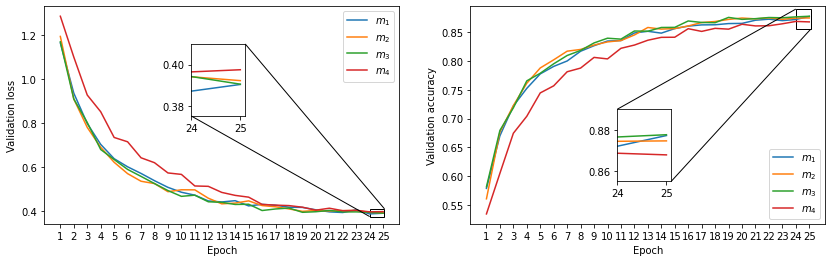

In [5]:
# Creating the figure and axes.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 4))

# Inset plots.
ax1_ins = inset_axes(ax1, 0.75, 1, loc = "upper left", bbox_to_anchor = (0.4, 0.85), bbox_transform=ax1.transAxes)
ax2_ins = inset_axes(ax2, 0.75, 1, loc = "upper left", bbox_to_anchor = (1.6, 0.55), bbox_transform=ax1.transAxes)

# Iterating over models.
for name in m_names:

  # Computing the x axis array.
  x = np.linspace(1, len(histories[name]["val_loss"]), len(histories[name]["val_loss"]), dtype = int)

  # Plotting.
  ax1.plot(x, histories[name]["val_loss"], label = r"${}$".format(name))
  ax2.plot(x, histories[name]["val_accuracy"], label = r"${}$".format(name))
  ax1_ins.plot(x, histories[name]["val_loss"])
  ax2_ins.plot(x, histories[name]["val_accuracy"])

x1_min, x1_max, y1_min, y1_max = 24, 25.1, 0.375, 0.41
x2_min, x2_max, y2_min, y2_max = 24, 25.1, 0.855, 0.89

ax1_ins.set_xlim(x1_min, x1_max)
ax1_ins.set_ylim(y1_min, y1_max)
ax2_ins.set_xlim(x2_min, x2_max)
ax2_ins.set_ylim(y2_min, y2_max)

mark_inset(ax1, ax1_ins, loc1 = 1, loc2 = 3)
mark_inset(ax2, ax2_ins, loc1 = 2, loc2 = 4)

ax1.set_ylabel("Validation loss")
ax1.set_xlabel("Epoch")
ax1.set_xticks(x)
ax1.legend()

ax2.set_ylabel("Validation accuracy")
ax2.set_xlabel("Epoch")
ax2.set_xticks(x)
ax2.legend()

plt.show()

Lastly, the following plot shows how $m_1$ (i.e. CMT-Ti with lightweight attention) and $m_3$ (i.e. CMT-Ti with no attention) are the best performing models. Moreover, it is also possible to notice how $m_2$ (i.e. CMT-Ti with standard attention) performs slightly worse than all other CMT models. As already mentioned, ResNet-18 is the worst performing model in terms of accuracy.

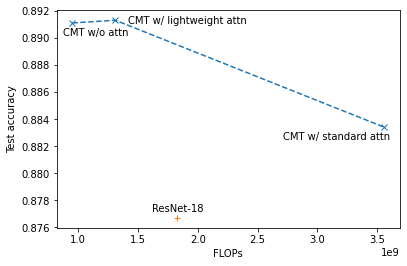

In [6]:
# Creating the figure and axes.
fig, ax = plt.subplots(1, 1, figsize = (6.15, 4))

# Plotting test accuracy vs. FLOPs.
ax.plot([flops["m_3"], flops["m_1"], flops["m_2"]], [test_acc["m_3"], test_acc["m_1"], test_acc["m_2"]], "--", marker = "x")
ax.plot(flops["m_4"], test_acc["m_4"], "--", marker = "+")

# Plotting texts.
ax.text(flops["m_1"] + 0.60e9, test_acc["m_1"],          texts["m_1"], ha = "center", va = "center")
ax.text(flops["m_2"] - 0.40e9, test_acc["m_2"] - 0.0007, texts["m_2"], ha = "center", va = "center")
ax.text(flops["m_3"] + 0.20e9, test_acc["m_3"] - 0.0007, texts["m_3"], ha = "center", va = "center")
ax.text(flops["m_4"],          test_acc["m_4"] + 0.0007, texts["m_4"], ha = "center", va = "center")

ax.set_ylabel("Test accuracy")
ax.set_xlabel("FLOPs")

plt.show()

This study suggests that, for the specific problem at hand, a CMT-Ti without attention is able to reach the same results of attention-based models, while also requiring a smaller number of FLOPs. However, results may vary when considering other problems/training settings. Unfortunately, due to the lack of computational resources, it was not possible to compare the characteristics of such models on different problems.

Moreover, the authors of CMT explicitely state how the CIFAR-10 images are upsampled from $32 \times 32$ to $224 \times 224$ images. Thus, the aforementioned performances could be due to such transformation. Future improvements of this work could try to modify the CMT architecture to be able to deal with $32 \times 32$ signals.

Despite the ability of computing long-range dependencies, standard multi-head self-attention did not perform as well as lightweight multi-head self-attention. Again, this could be due to the upsampled input resolution.

Lastly, it is also possible to notice how ResNet-18 is outperformed by all other models. This could be due to the specific setting used to train the models. Indeed, the original ResNet paper<sup>[[2]](#references)</sup> specifies a different training recipe. However, to be able to properly compare performances of all the aforementioned models, this notebook uses the same training procedure for all architectures.

## References <a name="references"></a>

1. Jianyuan Guo, Kai Han, Han Wu, Chang Xu, Yehui Tang, Chunjing Xu and Yunhe Wang. CMT: Convolutional Neural Networks Meet Vision Transformers, 2021. [https://arxiv.org/abs/2107.06263](https://arxiv.org/abs/2107.06263).

2. Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. Deep Residual Learning for Image Recognition, 2015. [https://arxiv.org/abs/1512.03385](https://arxiv.org/abs/1512.03385).